In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import random
cv2.ocl.setUseOpenCL(False)
import warnings
warnings.filterwarnings("ignore")


In [8]:
# === STEP 1: Load and Preprocess Images ===
train_img = cv2.imread(r'C:\Users\ronjd\OneDrive\Desktop\project public repo\image stitching\unstitched\train.jpg')
train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
train_gray = cv2.cvtColor(train_img, cv2.COLOR_RGB2GRAY)



In [9]:
query_img = cv2.imread(r'C:\Users\ronjd\OneDrive\Desktop\project public repo\image stitching\unstitched\query.jpg')
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
query_gray = cv2.cvtColor(query_img, cv2.COLOR_RGB2GRAY)

Text(0.5, 0, 'Train Image')

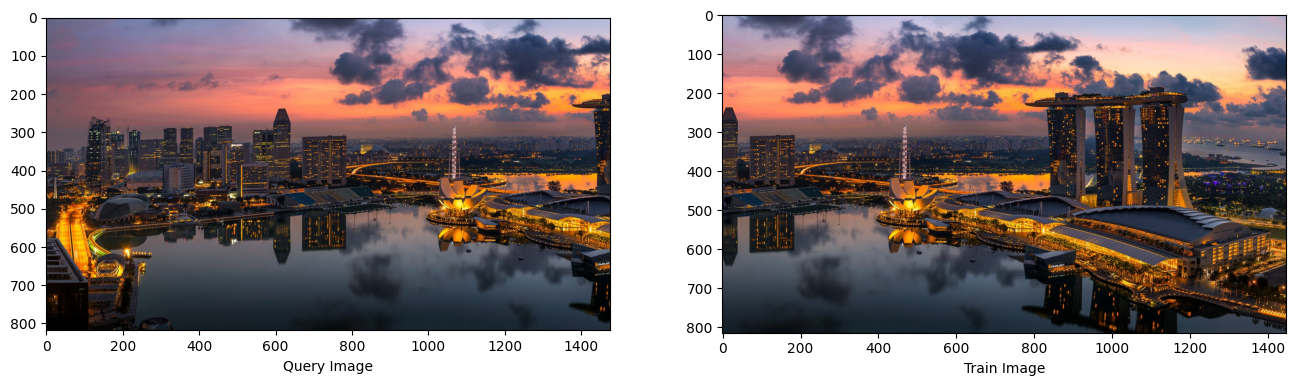

In [10]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.imshow(query_img)
ax1.set_xlabel('Query Image')
ax2.imshow(train_img)
ax2.set_xlabel('Train Image')

In [11]:
#harris corner detection 
def detect_harris_keypoints(gray_img, block_size=2, ksize=3, k=0.04, threshold_ratio=0.01):
    harris_response = cv2.cornerHarris(gray_img, block_size, ksize, k)
    harris_response = cv2.dilate(harris_response, None)
    threshold = threshold_ratio * harris_response.max()
    coords = np.argwhere(harris_response > threshold)
    keypoints = [cv2.KeyPoint(float(x), float(y), 3) for y, x in coords]
    return keypoints


In [40]:
def extract_patch_descriptors_with_norms(gray_img, keypoints, patch_size):
    half = patch_size // 2
    descriptors = []
    raw_norms = []
    valid_keypoints = []

    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        if x - half < 0 or x + half >= gray_img.shape[1] or y - half < 0 or y + half >= gray_img.shape[0]:
            continue
        patch = gray_img[y - half:y + half + 1, x - half:x + half + 1].astype(np.float32)
        patch = patch.flatten()

        # Store raw L2 norm before any processing
        raw_norms.append(np.linalg.norm(patch))

        # Now normalize the descriptor
        patch -= np.mean(patch)
        norm = np.linalg.norm(patch)
        if norm != 0:
            patch /= norm

        descriptors.append(patch)
        valid_keypoints.append(kp)

    return valid_keypoints, np.array(descriptors), np.array(raw_norms)


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

patch_sizes = [9, 11, 13]
all_raw_norms = []
labels = []

for patch_size in patch_sizes:
    _, _, raw_norms = extract_patch_descriptors_with_norms(query_gray, query_kp, patch_size)
    all_raw_norms.extend(raw_norms)
    labels.extend([f"{patch_size}x{patch_size}"] * len(raw_norms))


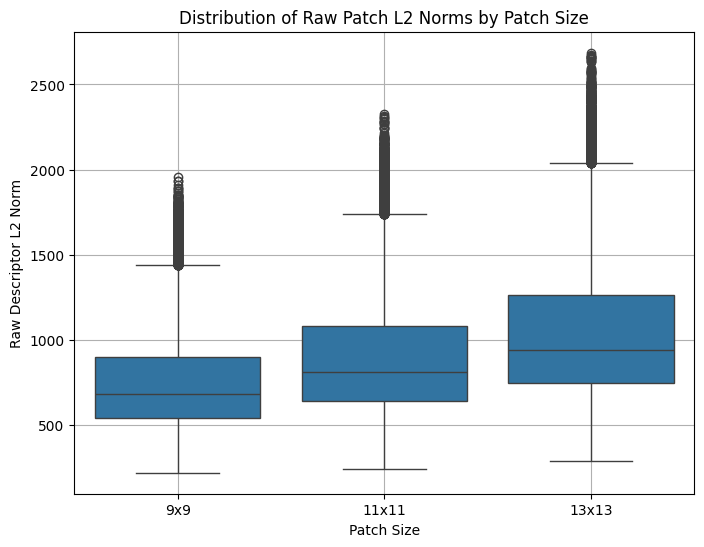

In [42]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=labels, y=all_raw_norms)
plt.title("Distribution of Raw Patch L2 Norms by Patch Size")
plt.xlabel("Patch Size")
plt.ylabel("Raw Descriptor L2 Norm")
plt.grid(True)
plt.show()


In [14]:
# === STEP 4: SIFT Descriptor Extraction at Harris Keypoints ===
sift = cv2.SIFT_create()
query_kp = detect_harris_keypoints(query_gray)
train_kp = detect_harris_keypoints(train_gray)
query_kp, query_desc = sift.compute(query_gray, query_kp)
train_kp, train_desc = sift.compute(train_gray, train_kp)

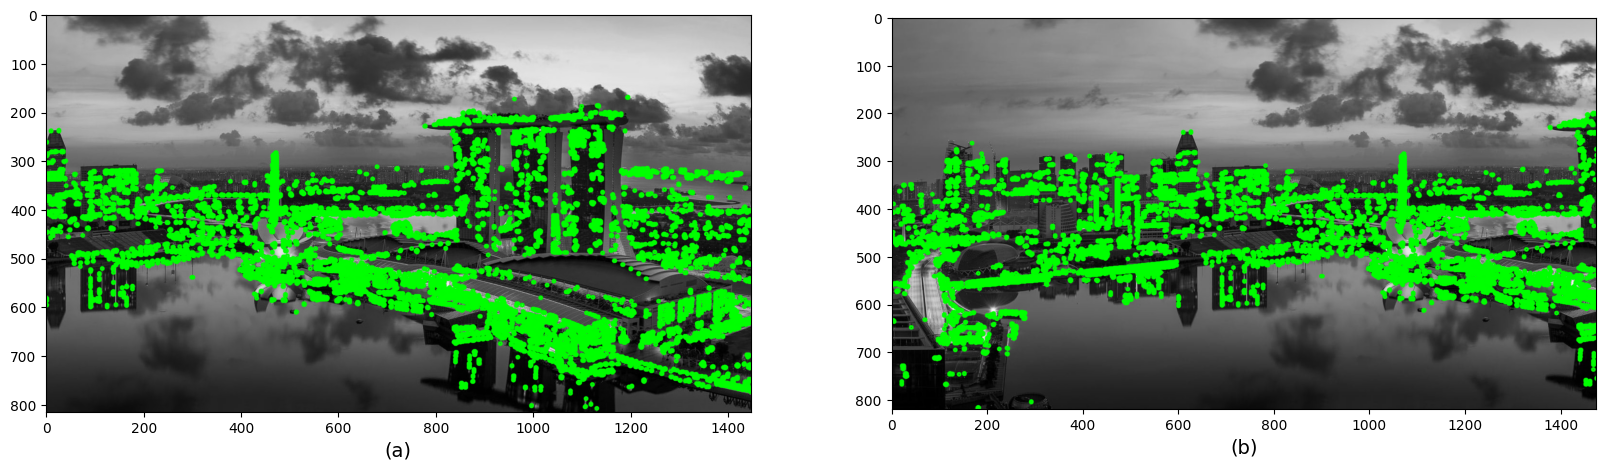

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout = False, figsize=(20, 8))
ax1.imshow(cv2.drawKeypoints(train_gray,    train_kp, None, color=(0, 255, 0)))
ax1.set_xlabel('(a)', fontsize=14)
ax2.imshow(cv2.drawKeypoints(query_gray, query_kp, None, color=(0, 255, 0)))
ax2.set_xlabel('(b)', fontsize=14)

plt.show()

In [16]:
# === STEP 3: Distance Metrics (Manual: Sampled Subset + Sensitivity) ===
def normalize_descriptors(desc):
    norms = np.linalg.norm(desc, axis=1, keepdims=True)
    return desc / (norms + 1e-8)

normalized_query = normalize_descriptors(query_desc)
normalized_train = normalize_descriptors(train_desc)


In [17]:
# Sample descriptors to speed up computation
query_sample_indices = np.random.choice(len(normalized_query), size=min(500, len(normalized_query)), replace=False)
train_sample_indices = np.random.choice(len(normalized_train), size=min(500, len(normalized_train)), replace=False)

In [18]:
#compute the euclidian distnce
matches = []
for i in query_sample_indices:
    dists = np.linalg.norm(normalized_train[train_sample_indices] - normalized_query[i], axis=1)
    best_j_local = np.argmin(dists)
    best_dist = dists[best_j_local]
    best_j = train_sample_indices[best_j_local]
    if best_dist < 0.5:  # Filter for strong matches only
        matches.append(cv2.DMatch(_queryIdx=i, _trainIdx=best_j, _distance=best_dist))


In [19]:
matches = sorted(matches, key=lambda x: x.distance)
matches = matches[:100]
print("total number of matches:", len(matches))

total number of matches: 33


In [51]:
# === STEP 5: Custom RANSAC for Affine Transformation ===
def custom_ransac_affine(matches, kp1, kp2, threshold=5.0, iterations=1000):
    best_inliers = []
    best_residuals = []
    best_M = None
    for _ in range(iterations):
        subset = random.sample(matches, 3)
        src_pts = np.float32([kp2[m.trainIdx].pt for m in subset]).reshape(-1, 2)
        dst_pts = np.float32([kp1[m.queryIdx].pt for m in subset]).reshape(-1, 2)
        M = cv2.getAffineTransform(src_pts, dst_pts)

        inliers = []
        residuals = []
        for m in matches:
            pt_train = np.array(kp2[m.trainIdx].pt + (1,))
            predicted = np.dot(M, pt_train)
            actual = np.array(kp1[m.queryIdx].pt)
            error = np.linalg.norm(predicted - actual)
            if error < threshold:
                inliers.append(m)
                residuals.append(error)

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_M = M
            best_residuals = residuals

    return best_M, best_inliers, best_residuals



In [52]:
M_affine, inlier_matches,residuals = custom_ransac_affine(matches, query_kp, train_kp)
print("Inliers:", len(inlier_matches))
print("Outliers:", len(matches) - len(inlier_matches))
avg_squared_residual = np.mean(np.square(residuals))
rmse = np.sqrt(np.mean(np.square(residuals)))
avg_residual = np.mean(residuals)
print("Average residual:", avg_residual)
print("RMSE:", rmse)
print("Average squared residual:", avg_squared_residual)
print("Best Affine Matrix (best_M):\n", M_affine)

Inliers: 17
Outliers: 16
Average residual: 1.6112165110615488
RMSE: 2.06161315569483
Average squared residual: 4.250248803733994
Best Affine Matrix (best_M):
 [[9.97479496e-01 5.35443765e-04 5.99983023e+02]
 [1.73692734e-03 9.94449668e-01 4.15159588e+00]]


Threshold = 1.0 → Avg Euclidean Error = 0.482 pixels
Threshold = 2.0 → Avg Euclidean Error = 0.980 pixels
Threshold = 3.0 → Avg Euclidean Error = 1.609 pixels
Threshold = 4.0 → Avg Euclidean Error = 1.558 pixels
Threshold = 5.0 → Avg Euclidean Error = 1.556 pixels
Threshold = 6.0 → Avg Euclidean Error = 1.601 pixels


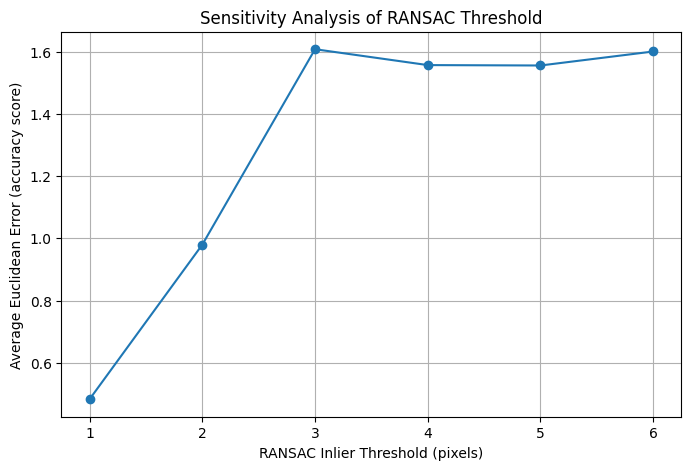

In [53]:
import matplotlib.pyplot as plt
import numpy as np

thresholds = [1.0, 2.0,3.0, 4.0, 5.0, 6.0]
accuracy_scores = []

for t in thresholds:
    M_affine, inlier_matches, residuals = custom_ransac_affine(matches, query_kp, train_kp, threshold=t)
    
    if not residuals:  # If no inliers, skip
        accuracy_scores.append(np.nan)
        continue

    avg_residual = np.mean(residuals)
    accuracy_scores.append(avg_residual)
    print(f"Threshold = {t} → Avg Euclidean Error = {avg_residual:.3f} pixels")

# Plot the sensitivity
plt.figure(figsize=(8, 5))
plt.plot(thresholds, accuracy_scores, marker='o')
plt.xlabel("RANSAC Inlier Threshold (pixels)")
plt.ylabel("Average Euclidean Error (accuracy score)")
plt.title("Sensitivity Analysis of RANSAC Threshold")
plt.grid(True)
plt.show()


In [22]:
def affine_to_homography(affine_matrix):
    """
    Converts a 2x3 affine matrix to a 3x3 homography matrix.
    """
    H = np.vstack([affine_matrix, [0, 0, 1]])
    return H


In [23]:
best_H = affine_to_homography(M_affine)
print("Homography Matrix (3x3):\n", best_H)


Homography Matrix (3x3):
 [[1.00116421e+00 4.21940928e-03 5.96613954e+02]
 [1.59489633e-03 1.00000000e+00 2.70813397e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


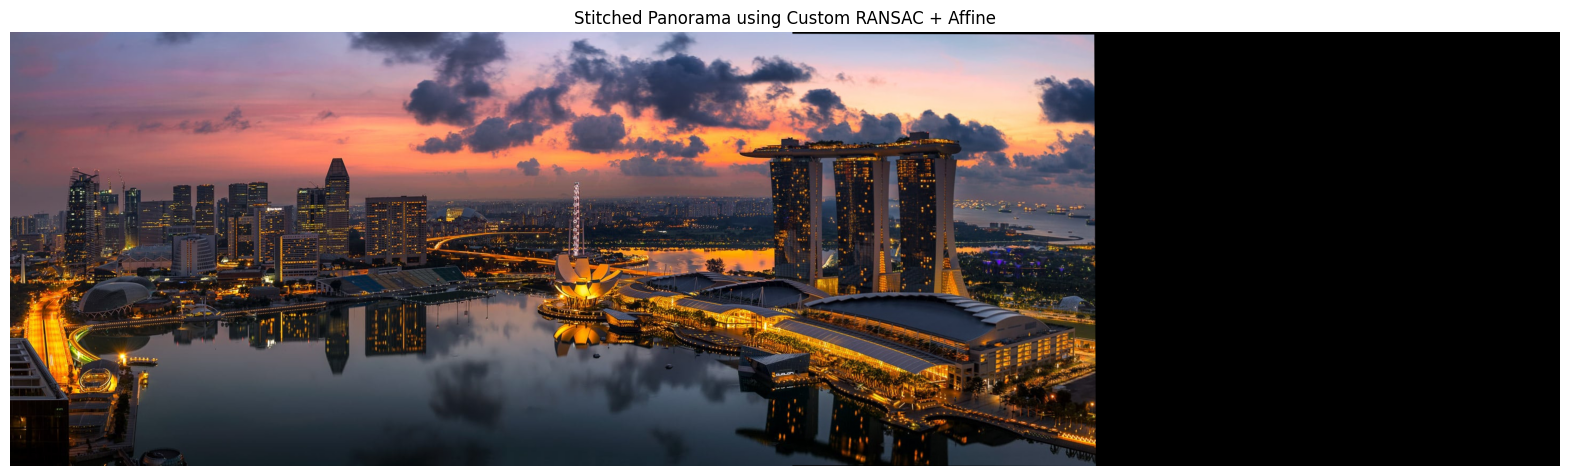

In [47]:
height, width = query_img.shape[:2]
warped_img = cv2.warpAffine(train_img, M_affine, (width + train_img.shape[1], height))
warped_img[0:height, 0:width] = query_img

plt.figure(figsize=(20, 8))
plt.imshow(warped_img)
plt.axis('off')
plt.title("Stitched Panorama using Custom RANSAC + Affine")
plt.show()



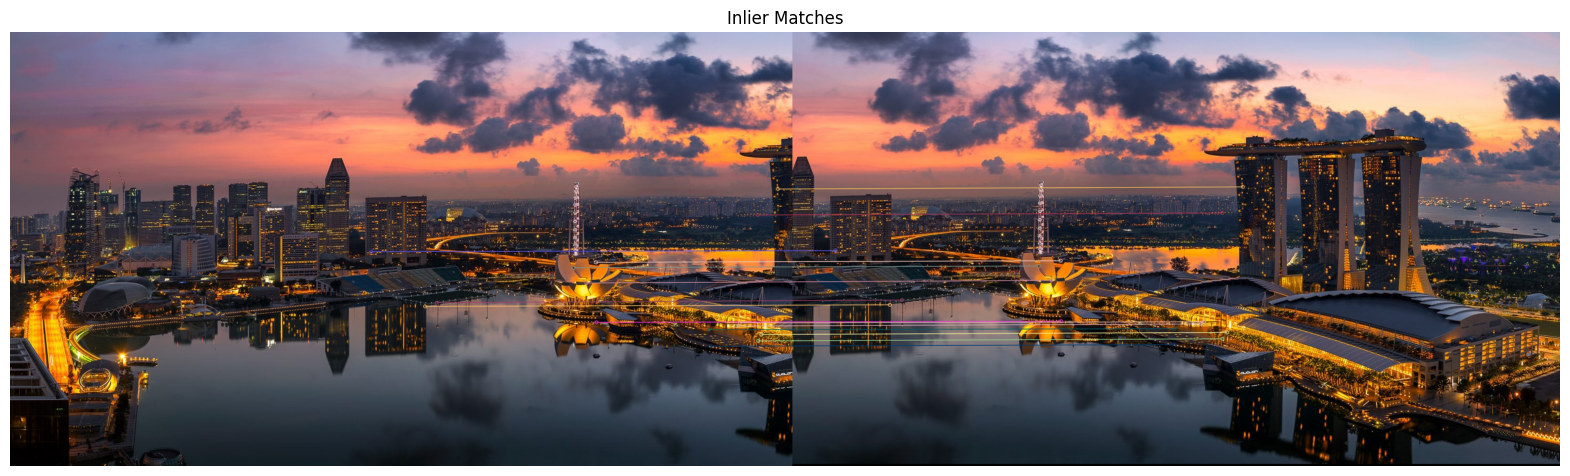

In [34]:
# === STEP 7: Draw Inlier Matches ===
inlier_vis = cv2.drawMatches(query_img, query_kp, train_img, train_kp, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20, 8))
plt.imshow(inlier_vis)
plt.axis('off')
plt.title("Inlier Matches")
plt.show()

In [32]:
# Image sizes
h1, w1 = query_img.shape[:2]
h2, w2 = train_img.shape[:2]

# Corners of train_img (image being warped)
train_corners = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
warped_corners = cv2.perspectiveTransform(train_corners, best_H)

# Also add corners of query_img (reference image)
query_corners = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)

# Combine all corners to find final panorama bounds
all_corners = np.concatenate((warped_corners, query_corners), axis=0)
[x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

# Translation to keep everything in positive space
translation = [-x_min, -y_min]
H_translation = np.array([
    [1, 0, translation[0]],
    [0, 1, translation[1]],
    [0, 0, 1]
])

# Warp train_img with updated homography
panorama_size = (x_max - x_min, y_max - y_min)
warped_img = cv2.warpPerspective(train_img, H_translation @ best_H, panorama_size)

# Paste query_img at the translated location
warped_img[translation[1]:translation[1]+h1, translation[0]:translation[0]+w1] = query_img


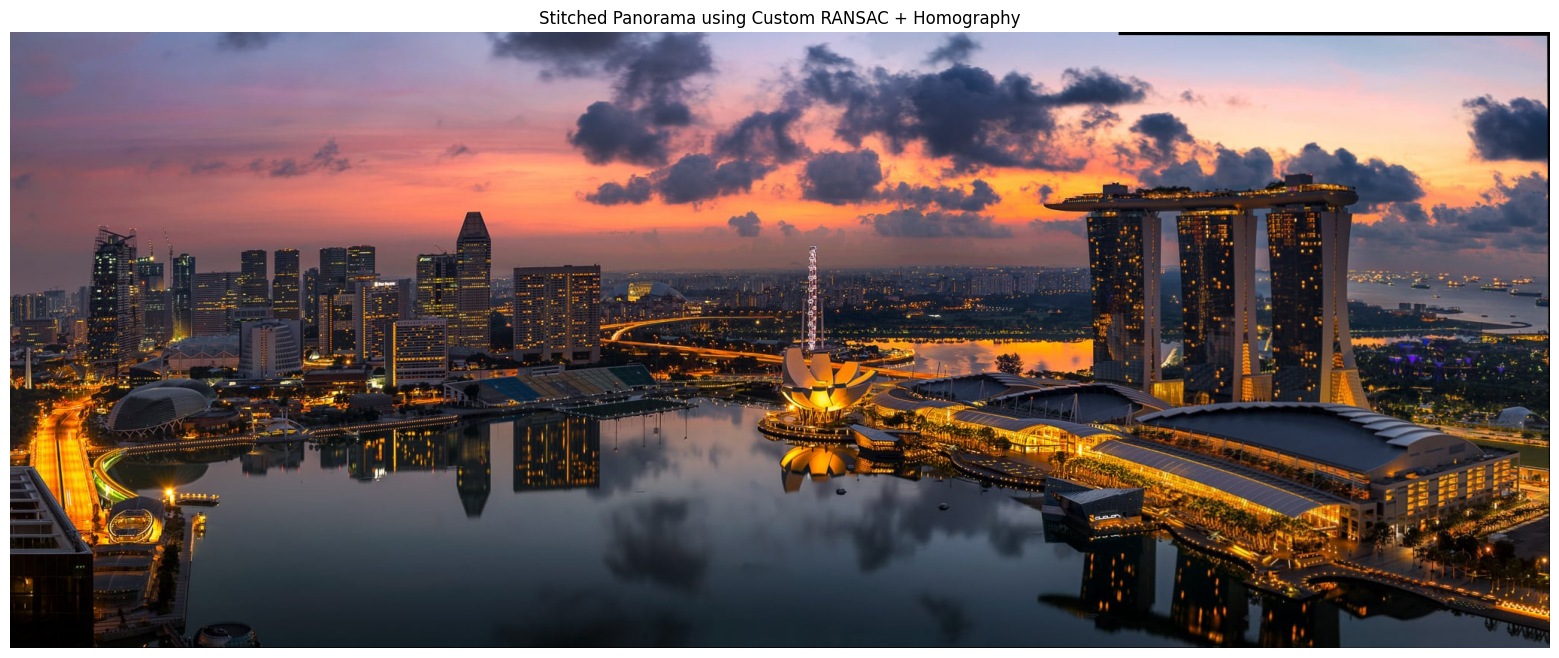

In [33]:
plt.figure(figsize=(20, 8))
plt.imshow(warped_img)
plt.axis('off')
plt.title("Stitched Panorama using Custom RANSAC + Homography")
plt.show()


In [48]:
# === STEP 8: Accuracy Score (Euclidean Distance) ===
def compute_accuracy_score(matches, kp1, kp2, M):
    errors = []
    for m in matches:
        pt_train = np.array(kp2[m.trainIdx].pt + (1,))
        projected = np.dot(M, pt_train)
        target = np.array(kp1[m.queryIdx].pt)
        error = np.linalg.norm(projected - target)
        errors.append(error)
    return np.mean(errors)

accuracy_score = compute_accuracy_score(inlier_matches, query_kp, train_kp, M_affine)
print(f"Accuracy Score (Avg Euclidean Distance): {accuracy_score:.2f} pixels")

Accuracy Score (Avg Euclidean Distance): 1.53 pixels


In [ ]:
import matplotlib.pyplot as plt

plt.plot(threshold, accuracy_score, marker='o')
plt.xlabel("RANSAC Threshold")
plt.ylabel("Average Euclidean Error")
plt.title("Sensitivity Analysis of RANSAC Threshold")
plt.grid(True)
plt.show()


NameError: name 'thresholds' is not defined